In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import h5py
from matplotlib.animation import FuncAnimation
from scipy.ndimage import median_filter

# Single Aggregate Input

In [9]:
h5_file_path = "F:/PhD_Franziska/Headon/RedBeads/subregion_cut1.h5"
with h5py.File(h5_file_path, 'r') as h5file:
    for dataset_name in h5file:
        print(f"Dataset Name: {dataset_name}")

Dataset Name: green
Dataset Name: red


In [10]:
h5_file_path = "F:/PhD_Franziska/Headon/RedBeads/subregion_cut1.h5"
with h5py.File(h5_file_path, "r") as h5f:
    green_channel = h5f["green"][:]
    red_channel = h5f["red"][:]

In [1]:
#plt.imshow(green_channel[300][110:220, 240:350])

In [12]:
def extract_single_aggregate(channel):
    # Extract the image information for al frames. 
    aggregate = []
    for i in range(np.shape(channel)[0]):
        aggregate.append(channel[i][110:220, 240:350])
    return np.array(aggregate)

In [13]:
aggregate = extract_single_aggregate(green_channel)
np.shape(aggregate)

(375, 110, 110)

In [14]:
h5_file_path = "single_aggregate_horizontal_cut1_all_frames_tissue.h5"
with h5py.File(h5_file_path, "w") as h5f:
     h5f.create_dataset("green", data = aggregate)

In [20]:
# # Make the video for single aggregat# fig = plt.figure(figsize = (5, 5), dpi=300)
# fig = plt.figure(figsize = (5, 5), dpi=300)
# def make_frame(i):
#     plt.clf()
#     # Plotting.
#     plt.title("t="+str(i))
#     plt.imshow(aggregate[i])
#     print("tu")

# myanim = FuncAnimation(fig, make_frame, frames = np.shape(aggregate)[0]-1, interval = 500)
# myanim.save("single_aggregate_tissue1.mp4", writer="ffmpeg")

# Mask Filter 
1. Could filter the aggregate out and apply for area definition.
2. Filter out the pixels which has the distance to center smaller than R --> approximatly a circle.

In [2]:
h5_file_path = "F:/PhD_Franziska/Headon/Polarisatioin/single_aggregate_horizontal_cut1_all_frames_tissue.h5"
with h5py.File(h5_file_path, "r") as h5f:
    single_aggregate = h5f["green"][:]

In [5]:
def circle_mask(center_x, center_y, radius, img):
    # Extract a circle on the image with given center and radius.
    # Create a grid of coordinates
    height, width = np.shape(img)[:2]
    Y, X = np.ogrid[:height, :width]
    
    # # Calculate the mask for the circle
    distance_from_center = np.sqrt((X - center_x)**2 + (Y - center_y)**2)
    circular_mask = distance_from_center <= radius
    
    # Apply the mask to get pixels within the circle
    circular_region = np.zeros_like(img)
    circular_region[circular_mask] = img[circular_mask]
    
    return circular_region

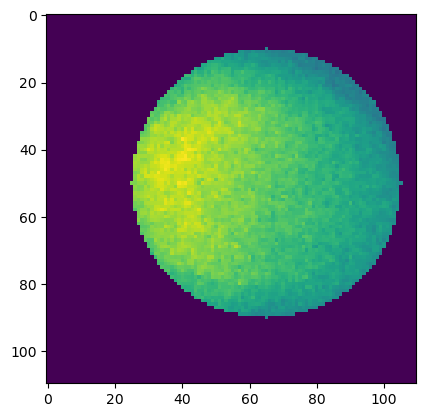

In [9]:
circle_region = circle_mask(65, 50, 40, single_aggregate[300])
plt.imshow(circle_region)

# Calculation of Polarisation: 
1. Get the vector from one pixel to the center and normalize the vector.
2. Multiple the vector with the current pixel intensity.
3. Do 1. and 2. for all pixels in the defined area from mask filter. Add them up --> A final vector.
The final vector points to the direction of polarisation and the length of the vector indicates the strength of polarisation. 

In [6]:
def polarisation_vector(center_x, center_y, radius, img):
    # Find coordinates of all non-zero elements
    circle_region = circle_mask(center_x, center_y, radius, img)
    non_zero_indices = np.argwhere(circle_region != 0)
    
    # Calculate vector components from the center to each non-zero element
    dy = non_zero_indices[:, 0] - center_y
    dx = non_zero_indices[:, 1] - center_x
    
    # Calculate the magnitude of each vector
    magnitude = np.sqrt(dx**2 + dy**2)
    
    # Avoid division by zero for any points exactly at the center
    magnitude[magnitude == 0] = 1
    
    # Normalize the vectors
    normalized_dx = dx / magnitude
    normalized_dy = dy / magnitude
    
    # Get the values of each non-zero element
    values = circle_region[non_zero_indices[:, 0], non_zero_indices[:, 1]]
    
    # Multiply vectors by corresponding non-zero values
    weighted_dx = normalized_dx * values
    weighted_dy = normalized_dy * values
    
    # Sum up the weighted vectors.
    sum_dx = np.sum(weighted_dx)
    sum_dy = np.sum(weighted_dy)

    # Final score would be the magnitude of the sumed up vector.
    magnitude_sum_vector = np.sqrt(sum_dx**2 + sum_dy**2)

    return magnitude_sum_vector, sum_dx, sum_dy

In [46]:
polarisation_vector(65, 50, 40, single_aggregate[300])

(224243.31427757753, -224236.89232937744, -1697.090644486947)

# Statistical Analysis of polarisation vector
1. The temporal dynamics of length of polarisation vector --> The strength of polarisation over time. Every frame has the same center and the region that will be considered to calculate the polarisation score.
2. Gather some single aggregates together and make the mean value statistics.

In [7]:
def temperal_polarisation(img_series, center_x, center_y, radius):
    
    total_frame = np.shape(img_series)[0]
    
    polarisation_score = []
    for i in range(total_frame):
        polarisation_score.append(polarisation_vector(center_x, center_y, radius, img_series[i])[0])
    
    plt.figure(figsize=(10, 4), dpi=300)
    plt.plot(polarisation_score, alpha=0.3, zorder=0)
    plt.plot(median_filter(polarisation_score, size=30, mode="nearest"), c="blue", zorder=1)
    plt.xlabel("frame")
    plt.ylabel("magnitude of final vector (unnormalized)")
    plt.show()
    
    # return ppolarisation_score

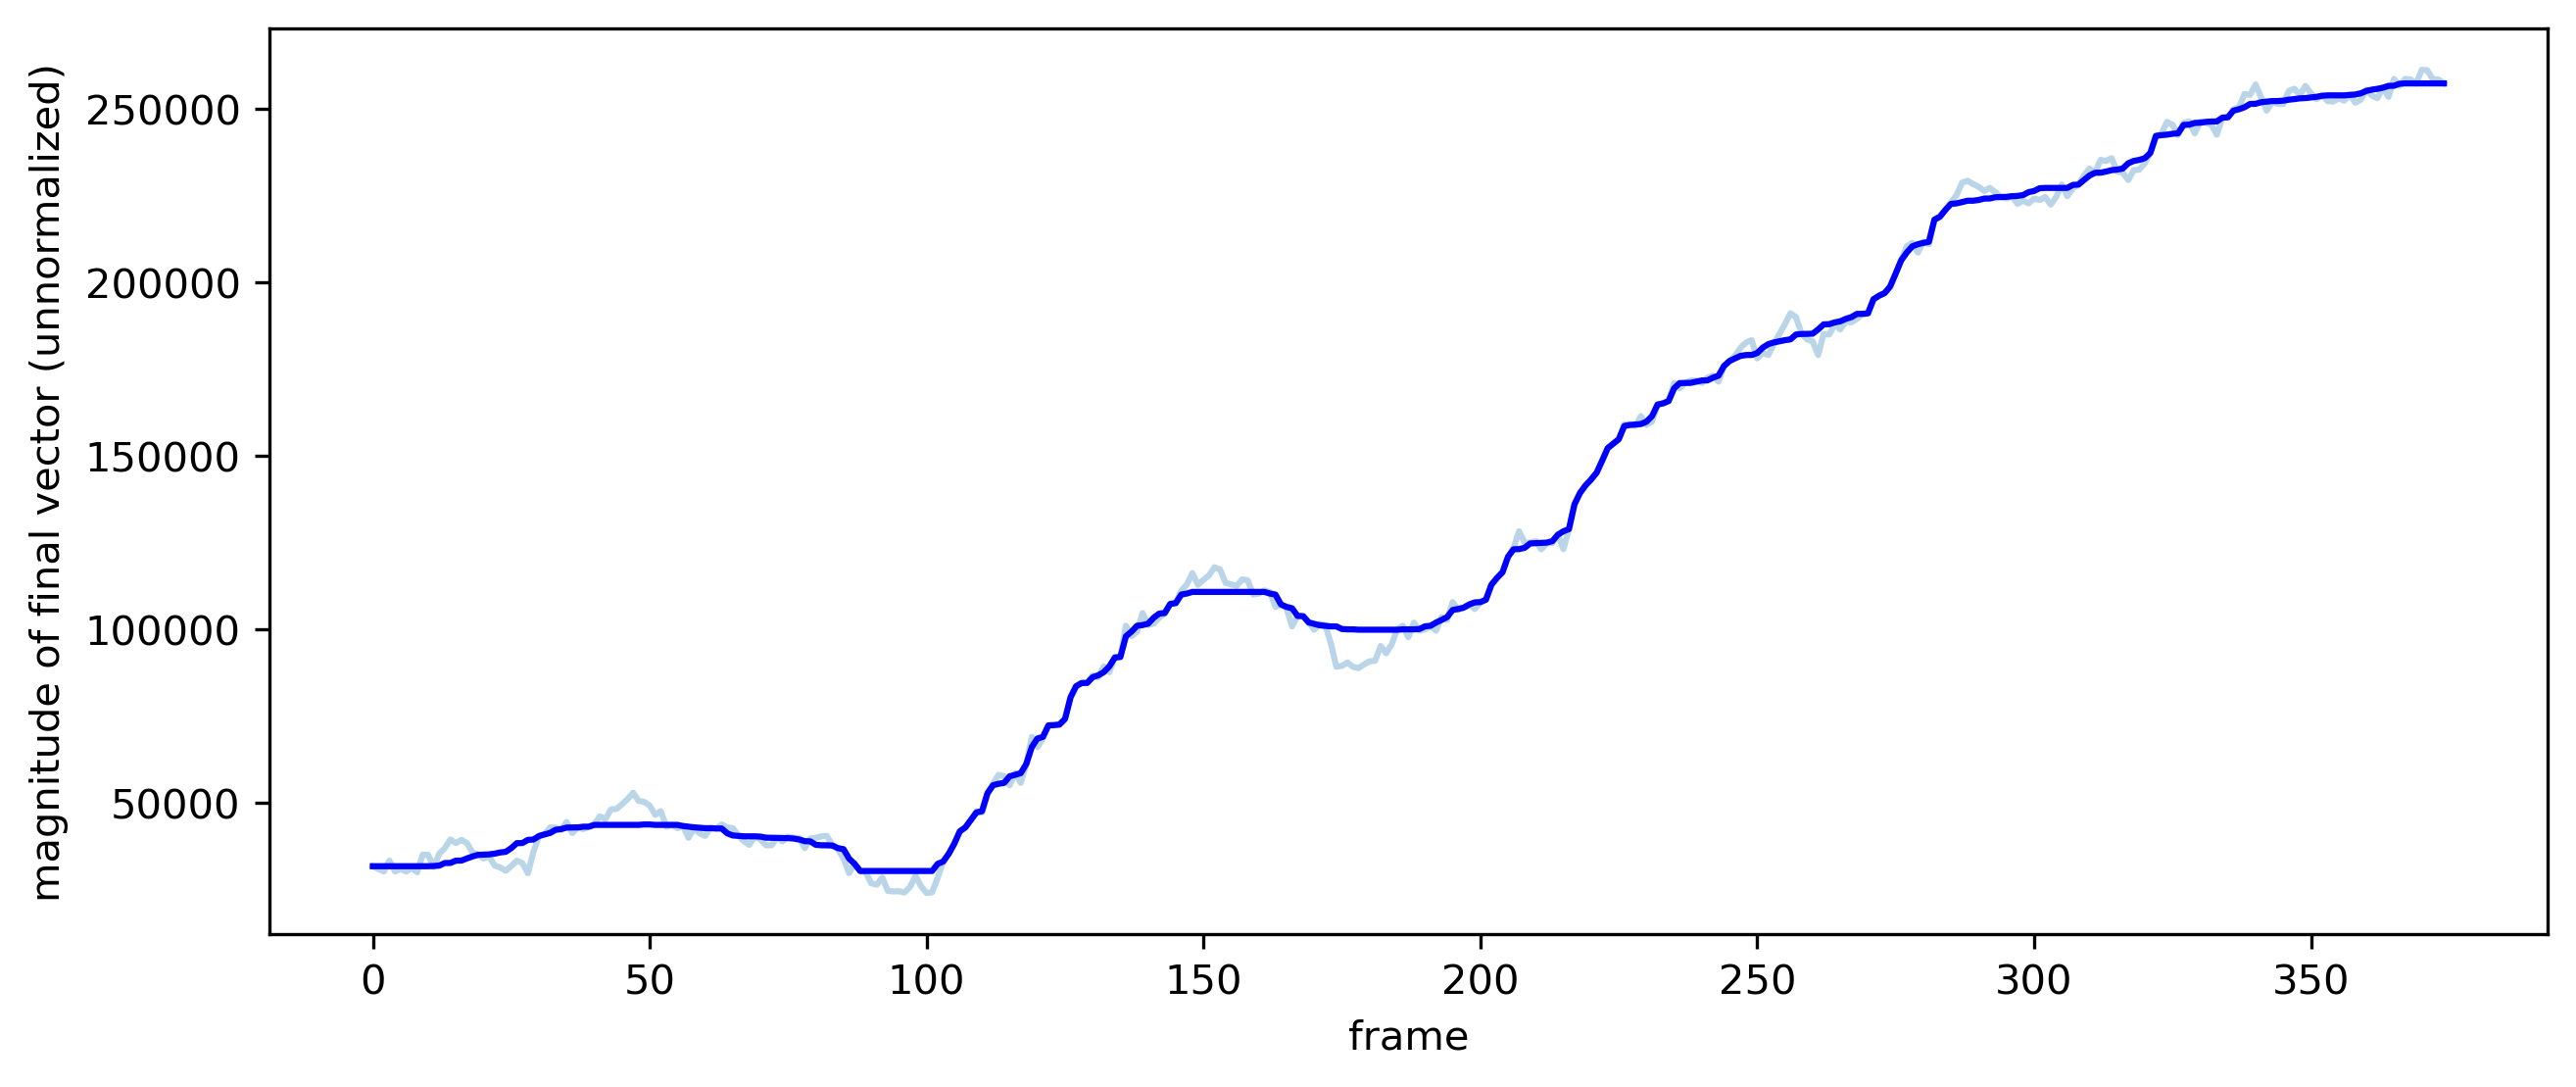

In [8]:
temperal_polarisation(single_aggregate, 65, 50, 40)

In [10]:
#TODO: probably gather more aggregates and do mean value statistics.
#TODO: normalization of the score. 